# *** READ ME ***  
This kernel is the second code (2/3) used for the 2024 G3P in-situ evaluation.  
This code allows to extract monthly GWSA from G3P data by clipping from the .shp of the aquifer. Version 1.12 with the Paris Basin is here take as an exemple.  
The inputs are: .nc annual datasets from G3P ; Grids_G3P.shp (.shp of the aquifer)   
The outputs are: v1.12_GWSA.xlsx  
# *****************

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import glob
import rioxarray
from shapely.geometry import mapping

# 1. Read aquifer .shp file

In [2]:
#os.environ['SHAPE_RESTORE_SHX'] = 'YES'
shp = gpd.read_file('Grids_G3P.shp')
shp

,geometry
0,"POLYGON ((-1.14397 50.70583, -0.64397 50.70583..."
1,"POLYGON ((-1.14397 50.20583, -0.64397 50.20583..."
2,"POLYGON ((-1.14397 49.70583, -0.64397 49.70583..."
3,"POLYGON ((-1.14397 49.70583, -0.64397 49.70583..."
4,"POLYGON ((-1.14397 49.70583, -0.64397 49.70583..."
...,...
520,"POLYGON ((6.85603 48.20583, 7.35603 48.20583, ..."
521,"POLYGON ((6.85603 47.70583, 7.35603 47.70583, ..."
522,"POLYGON ((6.85603 47.20583, 7.35603 47.20583, ..."
523,"POLYGON ((6.85603 46.70583, 7.35603 46.70583, ..."


In [3]:
shp.crs = 'EPSG:4326'
shp_wgs = shp.to_crs(epsg=4326)
shp_wgs

,geometry
0,"POLYGON ((-1.14397 50.70583, -0.64397 50.70583..."
1,"POLYGON ((-1.14397 50.20583, -0.64397 50.20583..."
2,"POLYGON ((-1.14397 49.70583, -0.64397 49.70583..."
3,"POLYGON ((-1.14397 49.70583, -0.64397 49.70583..."
4,"POLYGON ((-1.14397 49.70583, -0.64397 49.70583..."
...,...
520,"POLYGON ((6.85603 48.20583, 7.35603 48.20583, ..."
521,"POLYGON ((6.85603 47.70583, 7.35603 47.70583, ..."
522,"POLYGON ((6.85603 47.20583, 7.35603 47.20583, ..."
523,"POLYGON ((6.85603 46.70583, 7.35603 46.70583, ..."


<Figure size 2500x800 with 0 Axes>

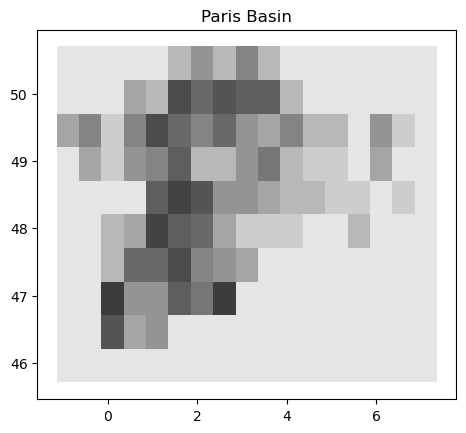

In [4]:
# Plot aquifer
plt.figure(figsize=(25,8))
ax = shp_wgs.plot(alpha=0.1, color='black')
plt.title('Paris Basin')

plt.show()

# 2. v1.12 global G3P data reading + clip .nc file into given .shp and generate area-average G3P GWSA 

In [5]:
v1_12 = pd.DataFrame()

# Get list of .nc files in same directory as script
file_list = glob.glob('*.nc')

# Loop through .netCDF files
for file_path in file_list:
    # Load .netCDF file
    dataset = rioxarray.open_rasterio(file_path)

    # Put the .netCDF in the correct format
    dataset.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    dataset.rio.write_crs("epsg:4326", inplace=True)

    # Clip the .netCDF with the shapefile
    clipped_data = dataset.rio.clip(shp_wgs.geometry.apply(mapping), shp_wgs.crs, drop=False)

    # Calculate the average by time
    mean_data = clipped_data.groupby('time').mean(...)

    # Convert to DataFrame
    df_mean_data = mean_data.to_dataframe()

    # Add data from each file to the final DataFrame
    v1_12 = pd.concat([v1_12, df_mean_data], axis=0)

# Remove column 'spatial_ref'
v1_12.drop(columns=['spatial_ref'], inplace=True)

# Convert indexes to strings with the YYYY-MM-DD format
v1_12.index = [index.strftime('%Y-%m-%d') for index in v1_12.index]

v1_12.rename(columns={'GWSA': 'v12_GWSA', 'uncertainty': 'v12_uncertainty'}, inplace=True)

v1_12

,v12_GWSA,v12_uncertainty
2002-04-16,27.537516,47.040745
2002-05-16,40.819672,47.351858
2002-08-16,61.402201,46.216928
2002-09-16,48.089820,46.966190
2002-10-16,60.341008,45.323741
...,...,...
2023-05-16,-11.237861,47.378401
2023-06-16,-73.481586,46.024181
2023-07-16,-99.910050,46.093174
2023-08-16,-70.526606,45.785023


In [6]:
v1_12.index = pd.to_datetime(v1_12.index)
# Resample to monthly frequency to obtain Nan months and compute the mean. Nan months from G3P are due to instrumental errors and generations switch
v1_12 = v1_12.resample('M').mean()
print(v1_12.to_string(index=True))

             v12_GWSA  v12_uncertainty
2002-04-30  27.537516        47.040745
2002-05-31  40.819672        47.351858
2002-06-30        NaN              NaN
2002-07-31        NaN              NaN
2002-08-31  61.402201        46.216928
2002-09-30  48.089820        46.966190
2002-10-31  60.341008        45.323741
2002-11-30  78.673099        46.159124
2002-12-31  87.533396        48.367961
2003-01-31  76.133842        53.342964
2003-02-28  81.797970        47.066944
2003-03-31  61.211662        46.343492
2003-04-30  31.913822        45.874123
2003-05-31  31.979906        46.446273
2003-06-30        NaN              NaN
2003-07-31  15.966810        46.910732
2003-08-31  11.934894        48.239475
2003-09-30  -1.210180        46.549873
2003-10-31 -24.360396        45.783650
2003-11-30  -1.534727        45.792917
2003-12-31   6.295632        47.010175
2004-01-31  29.041261        47.717945
2004-02-29  29.820519        47.302129
2004-03-31   9.270219        46.926547
2004-04-30  30.105594    

# 3. Plotting

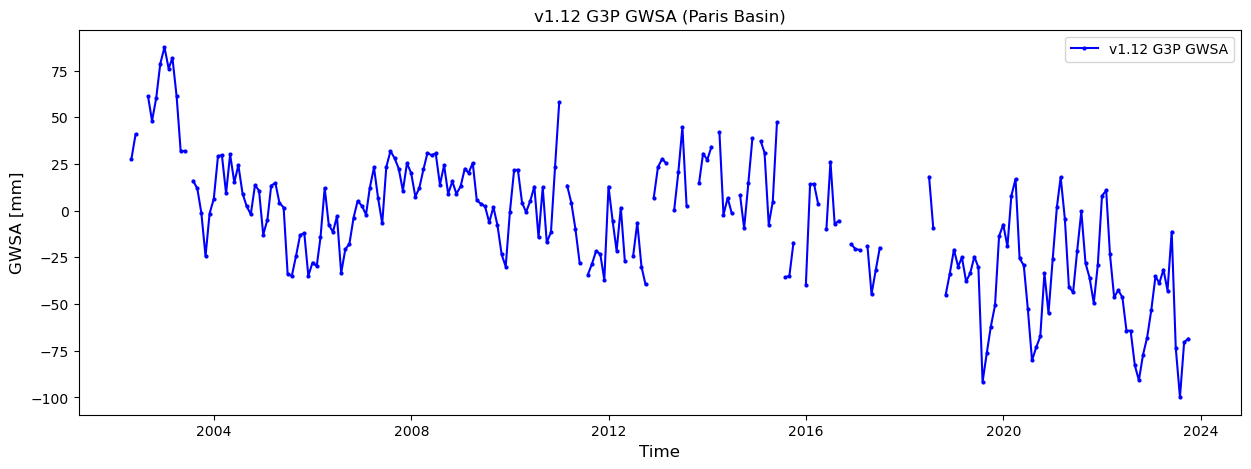

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(v1_12.index, v1_12['v12_GWSA'], c='blue', marker="o", markersize=2, label='v1.12 G3P GWSA')

plt.title('v1.12 G3P GWSA (Paris Basin)')
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('GWSA [mm]', fontsize = 12)
ax.legend()

plt.show()

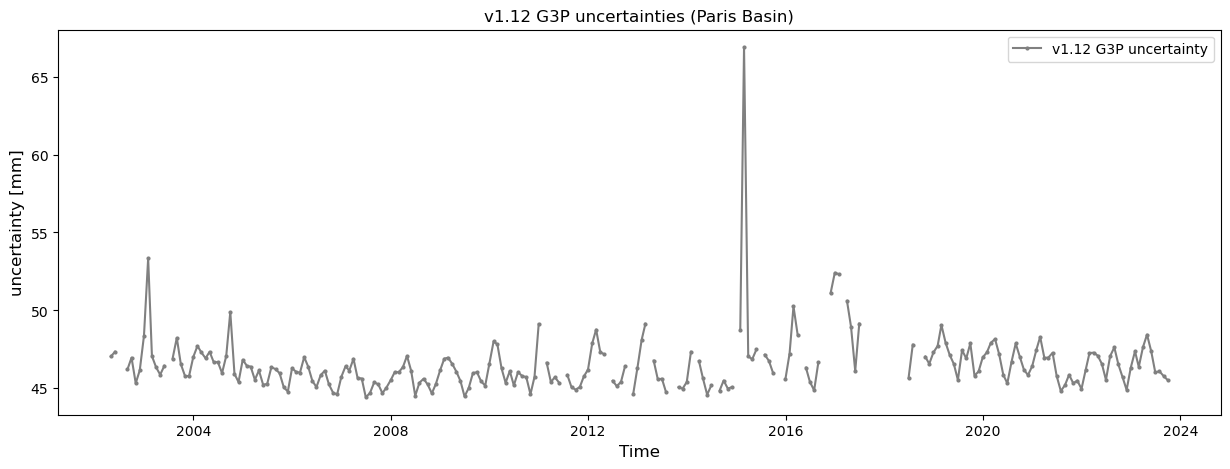

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(v1_12.index, v1_12['v12_uncertainty'], c='gray', marker="o", markersize=2, label='v1.12 G3P uncertainty')

plt.title('v1.12 G3P uncertainties (Paris Basin)')
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('uncertainty [mm]', fontsize = 12)
ax.legend()

plt.show()

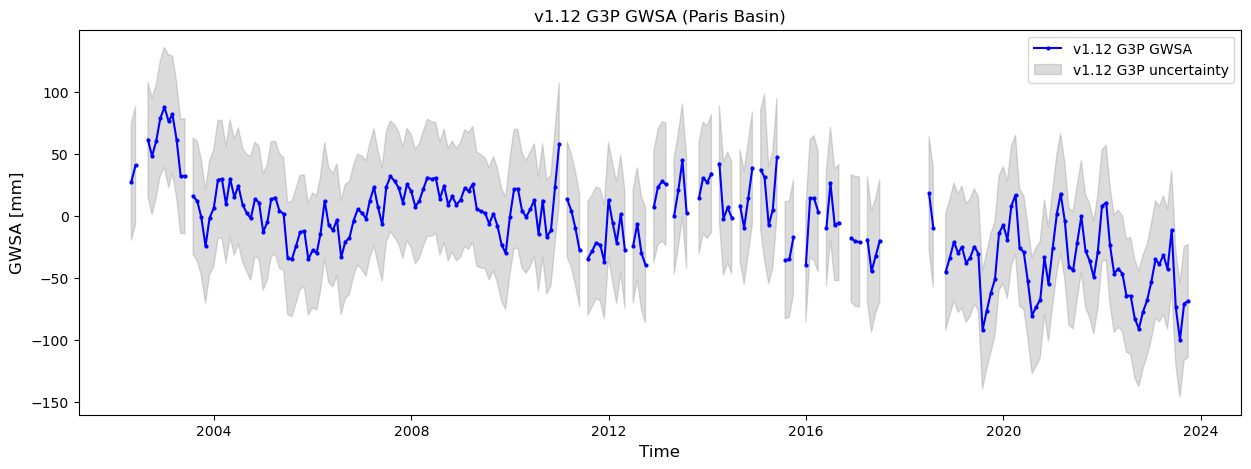

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(v1_12.index, v1_12['v12_GWSA'], c='blue', marker="o", markersize=2, label='v1.12 G3P GWSA')
ax.fill_between(v1_12.index, v1_12['v12_GWSA'] - v1_12['v12_uncertainty'], v1_12['v12_GWSA'] + v1_12['v12_uncertainty'], color='#888888', alpha=0.3, label='v1.12 G3P uncertainty')

plt.title('v1.12 G3P GWSA (Paris Basin)')
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('GWSA [mm]', fontsize = 12)
ax.legend()
plt.show()

# Exportation

In [10]:
# Export .xlsx file
v1_12.to_excel('ParisBasin_G3P_GWSA.xlsx')